# import

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import jieba as jb
import re
#如果還沒有安裝tensorflow2.0,請使用下面的指令安裝tensorflow
#!pip install tensorflow==2.0.0
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

2.17.0


# data

In [2]:
# #載入google的雲端硬碟
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/text_classfity/data

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/text_classfity/data


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/text_classfity/data/online_shopping_10_cats.csv')
print("數據總量: %d ." % len(df))
df.sample(10)

數據總量: 62774 .


,cat,label,review
47746,衣服,0,什么破店，说了衣服没到，还帮我去查一下，一天不说话，不是我找你你都不找我，那么不负责任
6151,平板,1,还不错，给我妈玩刚好，够大，没什么预装绑定的软件，很满意
10509,平板,0,第一：我有个SD卡在小米手里使用正常；在这部平板手机里只能读取，却不能写入，无法存储。第二：...
6956,平板,1,一直想给妈妈买个可打手机小平板，首选华为荣耀，对比一下，还是买了这款，最后一部我买到了，妈妈...
35539,洗发水,0,洗了好几天，很多头皮，不好用
11547,平板,0,今天把手机套摘下来突然发现左下角都没有接紧用手按有明显的松动，无语了已经，第一个小米nite...
22452,水果,0,苹果小的无法直视，跟图片压根就不是一回事，又青又酸又涩…全扔了…
56675,酒店,1,1、房间的风格很符合它的出身和环境，既时尚又有书卷味。很新很干净（包括是一般很容易显脏的地毯...
3736,书籍,0,不好看，没深度，适合初中生阅读。
51760,计算机,0,散热整体还可以，就是触摸板有些热呀。今天充电的时间有点长，开机的键似乎有点漏电，摸上去手指有...


### class

In [4]:
df[["cat"]].drop_duplicates().reset_index(drop=True)

,cat
0,书籍
1,平板
2,手机
3,水果
4,洗发水
5,热水器
6,蒙牛
7,衣服
8,计算机
9,酒店


In [5]:
print(df.cat.value_counts())
print()
print(df.cat.value_counts()/len(df));


cat
平板     10000
水果     10000
洗发水    10000
衣服     10000
酒店     10000
计算机     3992
书籍      3851
手机      2323
蒙牛      2033
热水器      575
Name: count, dtype: int64

cat
平板     0.159302
水果     0.159302
洗发水    0.159302
衣服     0.159302
酒店     0.159302
计算机    0.063593
书籍     0.061347
手机     0.037006
蒙牛     0.032386
热水器    0.009160
Name: count, dtype: float64


In [6]:
df[df.cat=='平板'][["review"]].sample(5).values

array([['商品本身不错，而且这小东西其实也不值钱，但京东这种行为非常让人气愤！！提醒大家！！'],
       ['什么破玩意，明明5G还说8G，5G我也忍了，最可恨的是存储连接不上电脑，管理个文件可能还用软件，我买个平板不是让你考验我智商的，你想累死我是不是！！！'],
       ['东西太差劲了 我买回来几天也没咋用 等我用的时候才发现老是跳屏 卡一下'],
       ['收到宝贝，物流快，华为质量很好，赞下。'],
       ['赠送的配件一件没有，这估计是个虚头！']], dtype=object)

In [7]:
df[df.cat=='手机'][["review"]].sample(5).values

array([['用了9个月以后开机也经常死机,不知道是电池还是手机有问题按键也不行,音质也不好,现在要到经销商去看看怎么回事'],
       ['外观还算新颖时尚，性价比不错，待机时间也令人满意'],
       ['待机时间短的要命两天'],
       ['1.重新开机后电话号码查询默认是英文，必须长按#键进入中文后才能查找电话。再关机重启后还是默认是英文。2.听音乐时，如果锁上键盘，手机左侧的播放/暂停钮不起作用提示插入免提装置。3.进入walkman听音乐时打开相机镜头不能进入拍摄画面。4.拍摄时快门速度和取景画面之间有一点时间滞后，发现拍完的照片和取景时的静止画面不同步。5.看电子书只能是Java的，不支持TXT和UMD的，同时看书时打开相机镜头也不能进入拍摄画面。'],
       ['不能上网']], dtype=object)

In [8]:
df[df.cat=='酒店'][["review"]].sample(5).values

array([['都从上海回来了，状态还在等待核实入住，说好的返现没兑现'],
       ['酒店房间好，阳光明媚，卫生间大，可惜没享受。司机说，到拉萨第一天不要洗澡。房间空调足。好像早餐是送到房间的？酒店地点是偏的，但我到拉萨的第一天反正是睡觉，也无所谓了。而且有人接机，挺好。因为睡了一天，酒店的具体也没多看'],
       ['一切都很差！服务不好！服务员素质没教养！特别是一楼餐厅。'],
       ['非常不错的一个酒店,我住的是标准大房,388一晚,很值,需要提点意见就是厕所里的地板排水严重不行.冲完凉后厕所地板上的水一直流不走,最后没办法拿浴巾来当地板...中餐不错,床.简直就一个爽字.超大!'],
       ['总体感觉还不错，就是从机场到酒店不是很方便，需要坐机场大巴，下车之后还打的（走的话还是有点距离的）。就这个价位而言，房间还算可以。就是商务中心的工作人员下班太早了，如果可以在晚上也接受我们的订票需要，那就会方便很多。宾馆反馈 2008年4月15日 ： 酒店反馈2008年4月8日：感谢阁下的宝贵意见，我们将考虑延长商务中心的服务时间，为客人提供更多的便利。']],
      dtype=object)

In [9]:
df[df.cat=='衣服'][["review"]].sample(5).values

array([['衣服不错，质量很好，面料舒服，颜色漂亮，大小合适，值得推荐，老板服务热情。'],
       ['裤子很好，质量也不错，没有色差，穿着很舒服，也不会掉色，棒棒哒'],
       ['15年购同一品牌牛仔裤两条，这次又是两条，感觉这次比上次的产品质量更加好，无论从做工还是用料都是越来越讲究，一次开心的购物！'],
       ['我只能说，这是我买过最划算最质优最修身，最好料最帅气的白色体恤了，我只想再买几件，明年夏天穿，这两件打底用！真心好，班尼路，之前在知乎上看过别人推荐的牌子，这是第一次购买！绝对推荐！绝对程序员必备品牌！大爱！    拍完照，发现最近胖了，为了这衣服，也得去健身了！！！???'],
       ['质量不错，做工精致，款式简单大方时尚，服务细心、耐心，物流给力，祝生意兴隆。']], dtype=object)

## 資料預處理

- 刪除文本中的標點符號,特殊符號,還要刪除一些無意義的常用詞(stopword)


In [10]:
# 1
#定義刪除除字母,數字，中文字以外的所有符號的函數
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line

def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

#載入停用詞
stopwords = stopwordslist("/content/drive/MyDrive/Colab Notebooks/text_classfity/data/cn_stopwords.txt")

# clean_review: remove 特殊符號 from review
df['clean_review'] = df['review'].apply(remove_punctuation)
df.sample(10)

# 2
#cut_review: 分詞，並過濾停用詞，由空格隔開的一個一個單獨的詞語 from clean_review
df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.head()

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.528 seconds.
DEBUG:jieba:Loading model cost 1.528 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,cat,label,review,clean_review,cut_review
0,书籍,1,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...,做父母一定要有刘墉这样的心态不断地学习不断地进步不断地给自己补充新鲜血液让自己保持一颗年轻的...,做 父母 一定 刘墉 心态 不断 学习 不断 进步 不断 补充 新鲜血液 保持 一颗 年轻 ...
1,书籍,1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,作者真有英国人严谨的风格提出观点进行论述论证尽管本人对物理学了解不深但是仍然能感受到真理的火...,作者 真有 英国人 严谨 风格 提出 观点 进行 论述 论证 物理学 了解 不深 仍然 感受...
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点为什么荷兰曾经县有欧洲最高的生产率...,作者 长篇大论 借用 详细 报告 数据处理 工作 计算结果 支持 其新 观点 荷兰 曾经 县...
3,书籍,1,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,作者在战几时之前用了拥抱令人叫绝日本如果没有战败就有会有美军的占领没胡官僚主义的延续没有战后...,作者 战 之前 拥抱 令人 叫绝 日本 没有 战败 会 美军 占领 没胡 官僚主义 延续 没...
4,书籍,1,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,作者在少年时即喜阅读能看出他精读了无数经典因而他有一个庞大的内心世界他的作品最难能可贵的有两...,作者 少年 时即 喜 阅读 看出 精读 无数 经典 一个 庞大 内心世界 作品 难能可贵 两...


# model

首先我們要資料集中拆分出訓練集和驗證集,我們將80%的資料作為訓練集,20%的資料作為驗證集，我們透過分層抽樣的方式來隨機抽樣，注意在這裡我們使用了sklearn的train_test_split的方法來抽樣,並使用了stratify參數來保證抽樣後,訓練集和驗證集中的各個類目的佔比與原數據集保持一致。

### data split

In [11]:
#拆分訓練集和測試集
X_train, X_validation, Y_train, Y_validation = train_test_split(df[['cut_review']],df[["cat"]], test_size = 0.2,stratify=df.cat)
print(len(X_train))
print(len(X_validation))

# print train/val data 分布
Y_train.cat.value_counts()/len(Y_train)
Y_validation.cat.value_counts()/len(Y_validation)

50219
12555


,count
cat,
衣服,0.159299
酒店,0.159299
洗发水,0.159299
平板,0.159299
水果,0.159299
计算机,0.063560
书籍,0.061330
手机,0.037037
蒙牛,0.032417


### confit

In [12]:
# 0. config
vocab_size = 5000
embedding_dim = 64
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

# 1. tokenizer context(x)
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train.cut_review.values)
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

##cat 處理後的data
print(len(list(word_index.items())))
print()
list(word_index.items())[:10]

# 2. padded
X_train_sequences = tokenizer.texts_to_sequences(X_train.cut_review.values)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_validation_sequences = tokenizer.texts_to_sequences(X_validation.cut_review.values)
X_validation_padded = pad_sequences(X_validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## cat padded
index = 10
print(X_train.cut_review.values[index])
print()
print(X_train_sequences[index])
print()
X_train_padded[index]

##
print("104 ->",reverse_word_index[104])
print("3 ->",reverse_word_index[3])
print("120 ->",reverse_word_index[120])
print()
print("贴身 ->",dict(list(word_index.items()))["贴身"])
print("1 ->",reverse_word_index[1])

# 3. tokenizer label(y)
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df.cat.values)

Y_training_cat_seq = np.array(label_tokenizer.texts_to_sequences(Y_train.cat.values))
Y_validation_cat_seq = np.array(label_tokenizer.texts_to_sequences(Y_validation.cat.values))

label_word_index = label_tokenizer.word_index

print(dict(list(label_word_index.items())))
print(Y_training_cat_seq.shape)
print()
print(Y_training_cat_seq[0])
print(Y_training_cat_seq[1])
print(Y_training_cat_seq[2])

## cat padded
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(X_train_padded[0]))
print('------------------------------------------------')
print(X_train.cut_review.values[0])

62653

酒店 外 内部 环境 不错 服务生 服务 意识 里面 吃 东东 贵 携程 确认 定单 时间 拖延 打车 宾馆 通知 没有 元 房间 只能 住 自助 旅行 偶 来讲 奢侈

[5, 829, 1036, 124, 3, 809, 13, 1268, 104, 34, 1602, 202, 105, 719, 4244, 93, 1, 690, 140, 994, 4, 109, 7, 126, 21, 1031, 2109, 3250, 1585, 1]

104 -> 里面
3 -> 不错
120 -> 大小

贴身 -> 8626
1 -> <OOV>
{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}
(50219, 1)

[5]
[5]
[1]
入住 <OOV> 宾馆 比较满意 宾馆 位置 比较 好找 <OOV> <OOV> <OOV> 三 几分钟 块钱 房间 比较 干净 算是 比较 宽敞 洗澡 热水 挺舒服 最好 地方 宾馆 外面 一条 <OOV> <OOV> 晚上 点 左右 开 很多 <OOV> 小吃 起码 <OOV> <OOV> 选择 很多 解决 吃 问题 方便 价格 相当 <OOV> 朋友 一起 两个 <OOV> 块钱 吃 <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
------------------------------------------------
入住 少林 宾馆 比较满意 宾馆 位置 比较 好找 客运站 打部 计程车 三 几分钟 块钱 房间 比较 干净 算是 比较 宽敞 洗澡 热水 挺舒服 最好 地方 宾馆 外面 一条 很旺 小吃街 晚上 点 左右 开 很多 麻辣烫 小吃 起码 二三十 档 选择 很多 解决 吃 问题 方便 价格 相当 评议 朋友

### model train

In [13]:
model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(X_train_padded,
                    Y_training_cat_seq,
                    epochs=num_epochs,
                    validation_data=(X_validation_padded, Y_validation_cat_seq),
                    verbose=2)

Epoch 1/10
1570/1570 - 29s - 19ms/step - accuracy: 0.7854 - loss: 0.6221 - val_accuracy: 0.8691 - val_loss: 0.3911
Epoch 2/10
1570/1570 - 43s - 27ms/step - accuracy: 0.8947 - loss: 0.3065 - val_accuracy: 0.8793 - val_loss: 0.3474
Epoch 3/10
1570/1570 - 29s - 19ms/step - accuracy: 0.9103 - loss: 0.2499 - val_accuracy: 0.8816 - val_loss: 0.3484
Epoch 4/10
1570/1570 - 38s - 24ms/step - accuracy: 0.9233 - loss: 0.2187 - val_accuracy: 0.8820 - val_loss: 0.3665
Epoch 5/10
Epoch 6/10
1570/1570 - 25s - 16ms/step - accuracy: 0.9367 - loss: 0.1735 - val_accuracy: 0.8801 - val_loss: 0.3932
Epoch 7/10
1570/1570 - 40s - 25ms/step - accuracy: 0.9426 - loss: 0.1573 - val_accuracy: 0.8786 - val_loss: 0.4318
Epoch 8/10
1570/1570 - 40s - 25ms/step - accuracy: 0.9472 - loss: 0.1445 - val_accuracy: 0.8771 - val_loss: 0.4369
Epoch 9/10
1570/1570 - 21s - 13ms/step - accuracy: 0.9524 - loss: 0.1295 - val_accuracy: 0.8730 - val_loss: 0.4923
Epoch 10/10
1570/1570 - 42s - 27ms/step - accuracy: 0.9569 - loss: 0.

### plot loss/acc

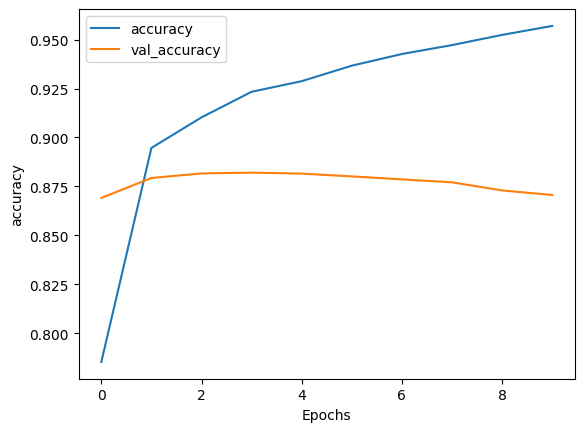

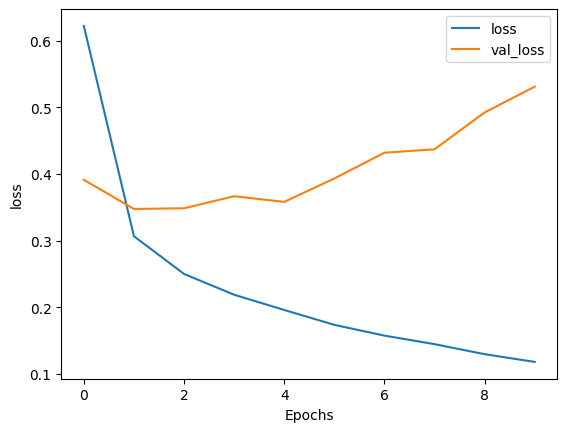

In [15]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### predict

In [16]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(X_validation_padded)
y_pred = y_pred.argmax(axis = 1)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


plot predict result + 準確度

{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}
accuracy 0.8706491437674233
              precision    recall  f1-score   support

           1       0.79      0.79      0.79      2000
           2       0.87      0.90      0.88      2000
           3       0.82      0.80      0.81      2000
           4       0.87      0.87      0.87      2000
           5       0.98      0.98      0.98      2000
           6       0.83      0.92      0.87       798
           7       0.93      0.93      0.93       770
           8       0.90      0.78      0.83       465
           9       1.00      1.00      1.00       407
          10       0.54      0.52      0.53       115

    accuracy                           0.87     12555
   macro avg       0.85      0.85      0.85     12555
weighted avg       0.87      0.87      0.87     12555

{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}


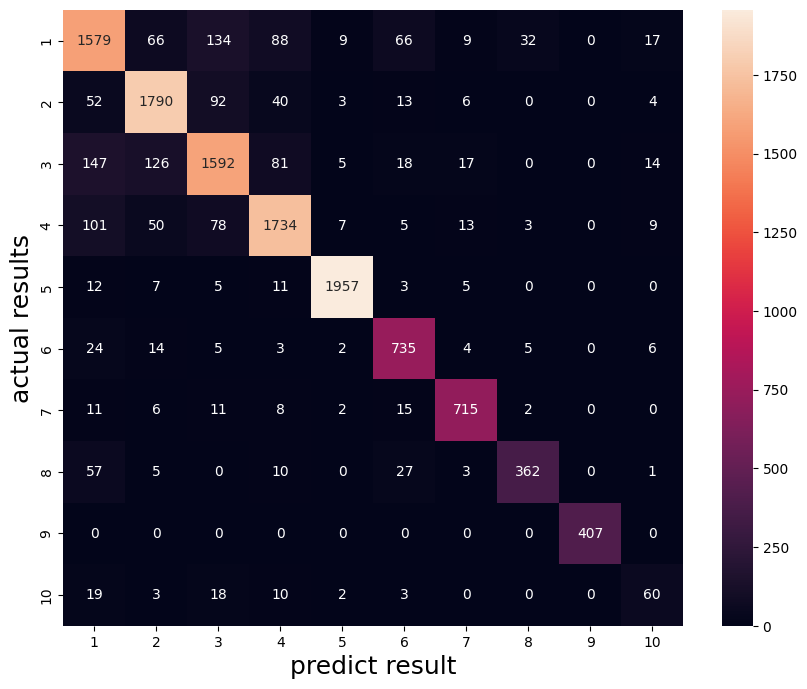

In [17]:
# confusion_matrix#
labels=[1,2,3,4,5,6,7,8,9,10]
conf_mat = confusion_matrix(Y_validation_cat_seq, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel('actual results',fontsize=18);
plt.xlabel('predict result',fontsize=18);
print(dict(list(label_word_index.items())))

# 準確度
from  sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, Y_validation_cat_seq))
print(classification_report(Y_validation_cat_seq, y_pred,target_names=[str(w) for w in labels]))
print(dict(list(label_word_index.items())))

